<a href="https://colab.research.google.com/github/brunogrbavac/BreastCancerClassification/blob/main/BreastCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Povezivanje s Google Diskom**
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title **Uvoz korištenih paketa**
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import cv2
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
from keras.models import load_model

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [ ]:
#@title **Funkcija za pretvaranje RGB -> Greyscale (za potrebe maski)**
#@markdown ***rgb2gray*** *(rgb)*
# iako su sve maske zapravo greyscale neke su pohranjene kao rgb, stoga ih moramo obraditi
def rgb2gray(rgb):
    if(rgb.ndim==3):
          r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
          gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
          return gray
    else:
      return rgb


In [ ]:
#@title **Funkcija za učitavanje podataka**
#@markdown ***LoadData*** *( imagesAndMasks = None, imgPath = None, maskPath = None, className = None, shape = 256, VGG = False)*
unetImagesAndMasks = { 'img' : [], 'mask' : [], 'class': [] }

# defining data Loader function
def LoadData( imagesAndMasks = None, imgPath = None, maskPath = None, className = None, shape = 256, VGG = False):
    # uzimamo sve datoteke iz mape
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []

    # datotekama kidamo kraj npr mask(154).png => mask(154
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    # uzimamo samo jedinstvene odjecke imena - jer imamo i maske i slike istoimene
    unames = list(set(unames))

    # u names i maskNames spremamo sva imena, i to masku i sliku na isti indeks u odgovarajucim nizovima
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    # sada koristimo kreirane nizove imena slika i maski
    for i in range (len(names)):
        #  ucitava sliku u niz
        img = plt.imread(imgAddr + names[i])
        
        # za VGG nam je potreban trokanalni ulaz
        if(VGG == True):
          mask = load_img(maskAddr + maskNames[i], color_mode = 'rgb', target_size=(shape,shape))
        else:
          mask = rgb2gray(plt.imread(maskAddr + maskNames[i]))
        
        # mijenjamo velicinu slike
        img = cv2.resize(img, (shape, shape))
        if(VGG == False):
          mask = cv2.resize(mask, (shape, shape)) 

        # pohranjujemo sliku i masku na iste indekse u odgovarajuce nizove
        imagesAndMasks['class'].append(className)
        if(VGG == True):
            imagesAndMasks['img'].append(img_to_array(img))
            imagesAndMasks['mask'].append(img_to_array(mask))
        else:
          imagesAndMasks['img'].append(img)
          imagesAndMasks['mask'].append(mask)

        
    return imagesAndMasks

In [ ]:
#@title **Učitavanje podataka za treniranje UNet mreže s Google Diska**
# ucitavamo training set pomocu iznad definirane funkcije, prvo dodajemo benigne pa maligne (redoslijed bez razloga)
unetImagesAndMasks = LoadData(unetImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/benign',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/benign',
                    className = 'benign',
                    shape = 256,
                    VGG=False)
unetImagesAndMasks = LoadData(unetImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/malignant',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/malignant',
                    className = 'malignant',
                    shape = 256,
                    VGG=False)
# ostali primjeri nisu trenirali na normal
unetImagesAndMasks = LoadData(unetImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/normal',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/normal',
                    className = 'normal',
                    shape = 256,
                    VGG=False)

In [ ]:
#@title **Izlist dataseta i provjera da su svi podaci odgovarajućeg formata**

# izlist dataseta, statistike radi
for disease in os.listdir('/content/drive/My Drive/Dataset_BUSI_with_GT'):
    count = len(os.listdir('/content/drive/My Drive/Dataset_BUSI_with_GT/{}'.format(disease)))
    print('Total number of images for', disease, 'is:', count)

# provjera da su svi podaci odgovarajućeg formata, jer nisu bili prije pretvorbe, reda radi
counter = 0
for image in unetImagesAndMasks['img']:
  if(str(image.shape) != "(256, 256, 3)"):
    counter = counter+1

print(counter)


counter = 0
for image in unetImagesAndMasks['mask']:
  if(str(image.shape) != "(256, 256)"):
    counter = counter+1
print(counter)

Total number of images for malignant is: 421
Total number of images for normal is: 276
Total number of images for benign is: 893
0
0


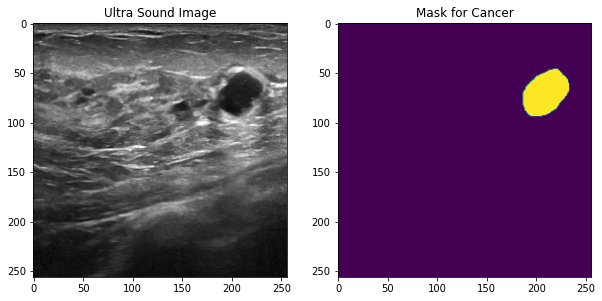

In [ ]:
#@title **Primjer slike i pripadajuće maske primjera**
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(unetImagesAndMasks['img'][73])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(unetImagesAndMasks['mask'][73])
plt.title('Mask for Cancer')
plt.show()



*   # *Batch Normalization*
Ubrzava treniranje kod dubokih neuralnih mreža tako da smanjuje varijaciju distribucije ulaza u slojeve nastalu zbog nasumičnostih početnih težina i nasumičnosti ulaza (*eng. Internal Covariate Shift*).
>https://en.wikipedia.org/wiki/Batch_normalization \
>https://medium.com/geekculture/is-batch-normalization-harmful-improving-normalizer-free-resnets-cf44f2fc0b2e

  >In neural networks, the output of the first layer feeds into the second layer the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does the distribution of inputs to subsequent layers. These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers. \
  >https://machinelearning.wtf/terms/internal-covariate-shift/

*   # *Kernel Initializer*
Samo postavlja početne težine na fancy način - koristeći neku statističku distribuciju težina.
>The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.

In [ ]:
#@title **Convolution block (includes 2 convolution layers)**
#@markdown ***ConvolutionBlock*** *(inputTensor, numberOfFilters, kernelSize = 3, doBatchNormalization = True)*
def ConvolutionBlock(inputTensor, numberOfFilters, kernelSize = 3, doBatchNormalization = True):
    # prva konvolucija
    x = tf.keras.layers.Conv2D(filters = numberOfFilters, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    if doBatchNormalization:
       x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # druga konvolucija
    x = tf.keras.layers.Conv2D(filters = numberOfFilters, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNormalization:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



*   # *Max Pooling*
Down scaleanje activation mapa ili bilo kakvih 2D mapa, za reprezentaciju sektora (16px sada npr. moramo predstavit s 1px) uzimamo onoga s najvećom vrijednošću u sektoru (od 16px).
>https://www.quora.com/What-is-Max-Pooling-2D

*  # *Padding*
>Zero-padding: Sometimes, it is convenient to pad the input matrix with zeros around the border, so that we can apply the filter to bordering elements of our input image matrix. A nice feature of zero padding is that it allows us to control the size of the feature maps. Adding zero-padding is also called wide convolution, and not using zero-padding would be a narrow convolution.

  Valid - dopušta da primjena konvolucija prirodno smanji dimenzije ulaza\
Same - prislino zadržava iste dimenzije, pa ih kasnije smanjimo npr. MaxPoolingom smanjujemo
>https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

* # *Concatenate*
Spaja izlaze (tensore) slojeva u jedan "izlaz" (tensor).<br/>***npr***. izlaz1: "A", izlaz2: "B" => izlaz: ["A","B"]
>https://keras.io/api/layers/merging_layers/concatenate/


In [ ]:
#@title **U-Net model**
#@markdown ***UNetModel*** *(inputImage, numFilters = 16, droupouts = 0.1, doBatchNormalization = True)*

def UNetModel(inputImage, numFilters = 16, droupouts = 0.1, doBatchNormalization = True):
    # U-Net encoder (downscaleing)
    c1 = ConvolutionBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = ConvolutionBlock(p1, numFilters * 2, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = ConvolutionBlock(p2, numFilters * 4, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = ConvolutionBlock(p3, numFilters * 8, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = ConvolutionBlock(p4, numFilters * 16, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    
    # U-Net decoder (upscaleing)
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = ConvolutionBlock(u6, numFilters * 8, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = ConvolutionBlock(u7, numFilters * 4, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = ConvolutionBlock(u8, numFilters * 2, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = ConvolutionBlock(u9, numFilters * 1, kernelSize = 3, doBatchNormalization = doBatchNormalization)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

    # Stvaramo Keras Model sa metodama za treniranje i zakljucivanje - navodimo ulaz i izlaz 
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

*   # *Transponirana konvolucija*
Tehnički "samo" unazadna konvolucija. Naime, ako nekom konvolucijom ulaza ***NxN*** dobivamo izlaz (aktivacijsku mapu) MxM pri čemu je ***M<N***, originalnu matricu ***NxN*** možemo dobiti ***klasičnim metodama interpolacije*** koje originalan podatak (piksel) izračunavaju na osnovu prosjeka okolnih podataka.
Transponirana konvolucija kao što joj samo ime kaže temelji se na prikazu konvolucije matricom konvolucije, naime primjenimo li transponiranu matricu konvolucije na izlaz konvolucije, dobivamo ulaz u konvoluciju.\
Prednosti ovog pristupa su što ***mogućnost treniranja transponirane konvolucije*** pridonosi ***očuvanju detalja*** podataka (pikseli nisu samo prosjek okolnih već "točne vrijednosti").\
Ovakvo ponašanje jako je korisno kod *upscale*-anja slika ili u raznim encoder decoder (autoencoder) mrežama.
>https://www.machinecurve.com/index.php/2019/12/10/conv2dtranspose-using-2d-transposed-convolutions-with-keras/

  >https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0<br/>

<br/>

* # *Dropout regularizacija*
Sprječava *overfitting* tako što u različitim prolazima treniranja ***dropuouta*** tj. **ignorira nasumične čvorove (određeni postotak)**. Konačnu mrežu stoga možemo zamisliti kao sumu više različitih "prorjeđenih" mreža.\
Loša strana ove regularizacije je što produljuje vrijeme potrebno za treniranje mreže.
>*You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.
The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.*\
\
>https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
>https://medium.com/analytics-vidhya/a-simple-introduction-to-dropout-regularization-with-code-5279489dda1e

*  # *U-Net (encoder decoder architecture)*
U-Net je konvolucijska neuralna mreža razvijena za potrebe segmentacije slika na području biomedicine, razvijena je od strane Olafa Ronnebergera pri Odjelu za računarstvo na Sveučilištu u Freiburgu.
>https://arxiv.org/abs/1505.04597

  <img src="https://i.ibb.co/K2Rgnwj/Snimka-zaslona-2022-02-04-190431.jpg" alt="drawing" width="700" />

  Problem koji se i nad ovim datasetom postavlja je problem semantičke segmentacije slike, jednostavnije rečeno problem klasifikacije svakog pojedinog piksela. Problem kojeg rješavaju klasične konvolucijske mreže rješavaju pokriva samo dio prethodno navedenog problema, odnsono klasificiraju cijelu sliku kao skup piksela. Priroda je konolucijskih mreža da kroz slojeve izlazi postaju sve manjih dimenzija  tj. izvlače se samo potrebne značajke slike. Iz ove "mape značajki" relativno malih dimenzija, koja sadrži informacije koje su nam potrebne da provedemo klasifikaciju, stoga je potrebno rekonstruirati mapu veličina ulazne slike kako bi se klasifikacija provela nad svakim pikselom. Proces dobivanja dimenzionalno veće mape značajki iz one manje naziva se ***upscaleing***, te se provodi prethodno navedenim trasnponiranim konvolucijama. Dodatan trik kojeg koristi U-Net je to što kao simetrična mreža (pojavljuju se po veličini odgovarajući parovi procesa pri downscaleanju podataka i upscaleanju) pri upscaleanju na ulazne podatke transponirane konvolucije konkatenira mape značajki dobivene odgovarajučćom konvolucijom u procesu downscaleanja (analogno spomenutoj mapi konvolucije koja se transponira da bi se vršila transponirana konvolucija i dobio originalni ulazni podatak).
  >Thus if we use a regular convolutional network with pooling layers and dense layers, we will lose the “WHERE” information and only retain the “WHAT” information which is not what we want. In case of segmentation we need both “WHAT” as well as “WHERE” information.

  >https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 \
  
  >https://developers.arcgis.com/python/guide/how-unet-works/ \

  >https://theaisummer.com/unet-architectures/ \

  >https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 \

  >https://towardsdatascience.com/u-net-b229b32b4a71 \


In [ ]:
#@title **Instanciranje U-Net modela i definiranje treniranja**

# definiramo početni tensor - ulaz 256x256 sa 3 kanala (rgb)
inputs = tf.keras.layers.Input((256, 256, 3)) 
maskMakingUnetInstance = UNetModel(inputs, droupouts= 0.1)

#https://keras.io/api/models/model_training_apis/
# za funkciju koštanja uzimamo binary_crossentropy - imamo samo 2 klase segmentacije (je tumor / nije tumor)
maskMakingUnetInstance.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
#@title **Definiranje Callback opcija za treniranje modela** *(checkpoint, reduceLearningRateOnPlateau i EarlyStopping)*

# https://keras.io/api/callbacks/
# ModelCheckpoint nam sprema model (njegove parametre tj. težine) kad on zadovolji neke uvjete (u ovom sučaju pohrani najboljeg na osnovu preciznosti na validation setu)
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/unetMaskModelCheckpoint2.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Smanjujemo stopu učenja ukoliko dođe do stagnacije u učenju (factor- za koliko smanjimo, patience - nakon koliko epoha stagniranja smanjujemo, min_delta - definiramo stagniranje)
reduceLearningRate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.0001)

# Zaustavljamo treniranje ukoliko se navedena ocjena ne promjeni kroz patience broj epoha
earlyStop = EarlyStopping(monitor="val_accuracy", verbose=1, patience=7)

In [ ]:
#@title **Treniranje modela za generiranje maski**
#https://keras.io/api/models/model_training_apis/
# Treniramo model, za povratnu vrijednost nam daje History objekt s podacima o funkciji koštanja i metrikama za pojedine epohe.

# lossesAndMetrics = maskMakingUnetInstance.fit(np.array(unetImagesAndMasks['img']), np.array(unetImagesAndMasks['mask']), validation_split=0.2, epochs = 30, verbose = 1, callbacks= [checkpoint, reduceLearningRate, earlyStop])

# maskMakingUnetInstance.save('/content/drive/My Drive/unetMaskModelManualAuto.hdf5')


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8748 
Epoch 00001: val_accuracy improved from -inf to 0.09538, saving model to /content/drive/My Drive/unetMaskModelCheckpoint2.hdf5
20/20 [==============================] - 549s 27s/step - loss: 0.4306 - accuracy: 0.8748 - val_loss: 10.0807 - val_accuracy: 0.0954 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9191 
Epoch 00002: val_accuracy did not improve from 0.09538
20/20 [==============================] - 528s 26s/step - loss: 0.2957 - accuracy: 0.9191 - val_loss: 14.2845 - val_accuracy: 0.0349 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9310 
Epoch 00003: val_accuracy did not improve from 0.09538
20/20 [==============================] - 544s 27s/step - loss: 0.2393 - accuracy: 0.9310 - val_loss: 13.5980 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 4/30
20/20 [=========================

In [ ]:
#@title **Ručna pohrana istrenrirana modela na Google Disk**
maskMakingUnetInstance.save('/content/drive/My Drive/unetMaskModelManual.hdf5')

In [ ]:
#@title **Grafički prikaz snovnih metrika treniranja U-Net**
plt.subplot(1,2,1)
plt.plot(lossesAndMetrics.history['loss'], label = 'training_loss')
plt.plot(lossesAndMetrics.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lossesAndMetrics.history['val_loss'], label = 'validation_loss')
plt.plot(lossesAndMetrics.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
#@title **Učitavanje treniranog modela s Google Diska**
trainedUnetModel = load_model('/content/drive/My Drive/unetMaskModelCheckpoint2.hdf5');

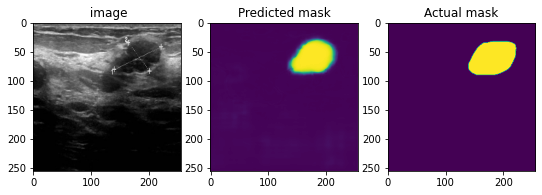

In [ ]:
#@title **Iscrtavanje slike, generirane i stvarne maske za primjer**

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')
    

Plotter(unetImagesAndMasks['img'][14], trainedUnetModel.predict(np.array([unetImagesAndMasks['img'][14]]))[0,:,:,0], unetImagesAndMasks['mask'][14])


In [ ]:
#@title **Učitavanje podataka za treniranje sa Google Diska** *(slučaj treninga VGG19 na pravim maskama)*
# Učitavamo slike i maske za VGG, ( reusamo vec postojeci loader pa ucitavamo i slike iako ih ne koristimo)

vggImagesAndMasks = { 'img' : [], 'mask' : [], 'class': [] }

vggImagesAndMasks = LoadData(vggImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/benign',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/benign',
                    className = 'benign',
                    shape = 224,
                    VGG = True)
vggImagesAndMasks = LoadData(vggImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/malignant',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/malignant',
                    className = 'malignant',
                    shape = 224,
                    VGG = True)
vggImagesAndMasks = LoadData(vggImagesAndMasks, 
                    imgPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/normal',
                    maskPath = '/content/drive/My Drive/Dataset_BUSI_with_GT/normal',
                    className = 'normal',
                    shape = 224,
                    VGG = True)

In [ ]:
#@title **Metrike treniranja, validacije i testiranja** *(preciznost i F1)*
from sklearn.metrics import f1_score

def trainValTestMetrics(model, x_train, y_train, x_val, y_val, x_test, y_test):

    train_loss, train_acc = model.evaluate(x_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(x_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(x_test, y_test.toarray())

    y_pred = model.predict(x_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    f1_measure = f1_score(y_true_label, y_pred_label, average = 'weighted')

    print("Train accuracy = " + str(train_acc))
    print("Validation accuracy = " + str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("F1 = " + str(f1_measure))

In [ ]:
#@title **Definiranje funkcije za iscrtavanje podatak o treniranju.**
def plotTrainData(accuracy, validation_accuracy, loss, validation_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Metrics")

    ax1.plot(range(1, len(accuracy) + 1), accuracy)
    ax1.plot(range(1, len(validation_accuracy) + 1), validation_accuracy)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(validation_loss) + 1), validation_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

In [ ]:
#@title **Definiranje VGG19 mreže**
# koristimo težine dobivene treniranjem na ImageNetu
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)

for l in base_model.layers:
    l.trainable = False

def VGG19():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [ ]:
model = VGG19()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                      

In [ ]:
#@title **Podjela podataka u train, validation i test set - SL1.** *(treniranje na stvarnim maskama)*
encoder  = OneHotEncoder()

encoded_classesVGG = encoder.fit_transform(np.array(vggImagesAndMasks['class']).reshape(np.array(vggImagesAndMasks['class']).shape[0],1))

masksForVGG_trainAndVal, masksForVGG_test, classesVGG_trainAndVal, classesVGG_test = train_test_split(np.array(vggImagesAndMasks['mask']), encoded_classesVGG, test_size=0.15, shuffle=True, random_state=42, stratify=encoded_classesVGG.toarray())
masksForVGG_train, masksForVGG_val, classesVGG_train, classesVGG_val = train_test_split(masksForVGG_trainAndVal, classesVGG_trainAndVal, test_size=0.1, random_state=42, stratify = classesVGG_trainAndVal.toarray())


In [ ]:
#@title **Podjela podataka u train, validation i test set - SL2.** *(treniranje na generiranim maskama)*
encoder  = OneHotEncoder()
encodedClassesUNETtoVGG = encoder.fit_transform(np.array(unetImagesAndMasks['class']).reshape(np.array(unetImagesAndMasks['class']).shape[0],1))

# train_test_split koristimo za podjelu niza primjera i pripadnih im klasa u setove za treniranje i testiranje
imagesForMaskGeneration_trainAndVal, imagesForMaskGeneration_test, classes_trainAndVal, classes_test = train_test_split(np.array(unetImagesAndMasks['img']), encodedClassesUNETtoVGG, test_size=0.15, shuffle=True, random_state=42, stratify=encodedClassesUNETtoVGG.toarray())
imagesForMaskGeneration_train, imagesForMaskGeneration_val, classes_train, classes_val = train_test_split(imagesForMaskGeneration_trainAndVal, classes_trainAndVal, test_size=0.1, random_state=42, stratify = classes_trainAndVal.toarray())

generatedMasks_train = trainedUnetModel.predict(imagesForMaskGeneration_train)
generatedMasks_val = trainedUnetModel.predict(imagesForMaskGeneration_val)
generatedMasks_test = trainedUnetModel.predict(imagesForMaskGeneration_test)


In [ ]:
#@title **Obrada generiranih maski u format potreban za treniranje VGG**
generatedMasks_train_224 = [];
generatedMasks_val_224 = [];
generatedMasks_test_224 = [];

for img in generatedMasks_train:
  generatedMasks_train_224.append( np.array(tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)), [224, 224])))

for img in generatedMasks_val:
  generatedMasks_val_224.append(np.array(tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)), [224, 224])))

for img in generatedMasks_test:
  generatedMasks_test_224.append(np.array(tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)), [224, 224])))



In [ ]:
#@title **Definiranje Callback opcija za treniranje VGG** *(EarlyStopping)*
earlyStopVGG = EarlyStopping(monitor="val_acc", patience=7, verbose=1)
# Smanjujemo stopu učenja ukoliko dođe do stagnacije u učenju (factor- za koliko smanjimo, patience - nakon koliko epoha stagniranja smanjujemo, min_delta - definiramo stagniranje)
reduceLearningRateVGG = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.0001)
checkpointVGG = ModelCheckpoint(filepath='/content/drive/My Drive/vggModelCheckpointGenerated1321852.hdf5', monitor='val_acc', verbose=1, save_best_only=True)


In [ ]:
#@title **Slučaj 1:** *trening VGG19 na pravim maskama (pokazao se kao lošiji izbor)*
# Treniranje na pravin maskama
lossesAndMetricsVGG = model.fit(masksForVGG_train, classesVGG_train.toarray(), batch_size = 16, epochs=30, validation_data = (masksForVGG_val, classesVGG_val.toarray()), callbacks=[earlyStopVGG,reduceLearningRateVGG,checkpointVGG])
trainValTestMetrics(model, masksForVGG_train, classesVGG_train, masksForVGG_val, classesVGG_val, masksForVGG_test, classesVGG_test)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 2.4301 - acc: 0.6963
Epoch 00001: val_acc improved from -inf to 0.97015, saving model to /content/drive/My Drive/vggModelCheckpoint2.hdf5
38/38 [==============================] - 416s 11s/step - loss: 2.4301 - acc: 0.6963 - val_loss: 0.4953 - val_acc: 0.9701 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 1.7175 - acc: 0.7987
Epoch 00002: val_acc improved from 0.97015 to 0.98507, saving model to /content/drive/My Drive/vggModelCheckpoint2.hdf5
38/38 [==============================] - 412s 11s/step - loss: 1.7175 - acc: 0.7987 - val_loss: 0.3468 - val_acc: 0.9851 - lr: 0.0010
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 1.7018 - acc: 0.8037
Epoch 00003: val_acc did not improve from 0.98507
38/38 [==============================] - 410s 11s/step - loss: 1.7018 - acc: 0.8037 - val_loss: 0.2845 - val_acc: 0.9851 - lr: 0.0010
Epoch 4/30
38/38 [==========================

AttributeError: ignored

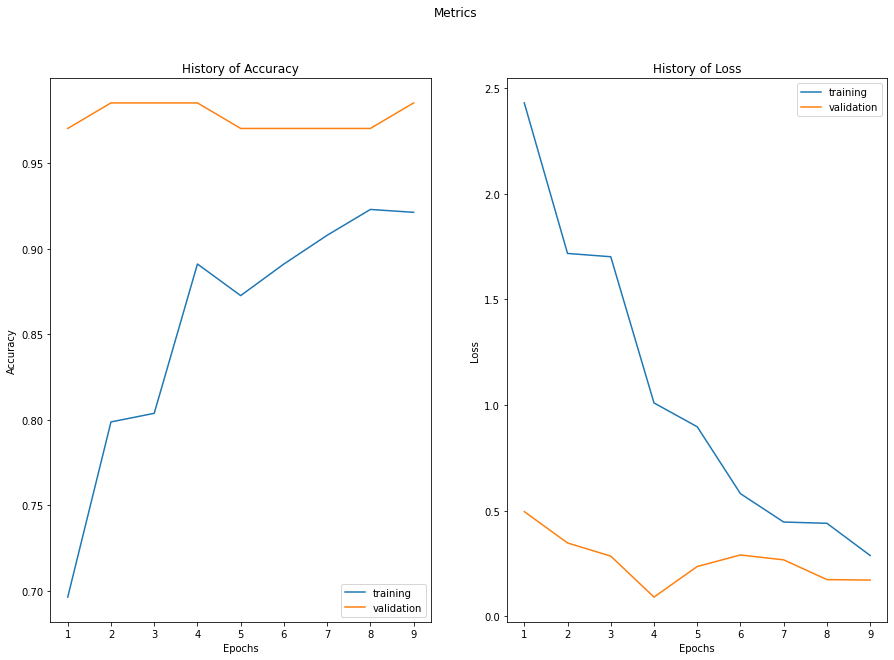

In [ ]:
model.save('/content/drive/My Drive/VGGModelManualNewValOnReal.hdf5')
plotTrainData(lossesAndMetricsVGG.history['acc'], lossesAndMetricsVGG.history['val_acc'], lossesAndMetricsVGG.history['loss'], lossesAndMetricsVGG.history['val_loss'])

In [ ]:
trainValTestMetrics(model, np.array(generatedMasks_train_224), classes_train, np.array(generatedMasks_val_224), classes_val, np.array(generatedMasks_test_224), classes_test)

4/4 [==============================] - 73s 18s/step - loss: 16.2574 - acc: 0.1709
Train accuracy = 0.17114093899726868
Validation accuracy = 0.16417910158634186
Test accuracy = 0.17094017565250397
F1 = 0.049909538960633854


Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 4.3231 - acc: 0.5252 
Epoch 00001: val_acc improved from -inf to 0.26866, saving model to /content/drive/My Drive/vggModelCheckpointGenerated1321852.hdf5
38/38 [==============================] - 416s 11s/step - loss: 4.3231 - acc: 0.5252 - val_loss: 1.5105 - val_acc: 0.2687
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 3.4464 - acc: 0.5369
Epoch 00002: val_acc improved from 0.26866 to 0.28358, saving model to /content/drive/My Drive/vggModelCheckpointGenerated1321852.hdf5
38/38 [==============================] - 415s 11s/step - loss: 3.4464 - acc: 0.5369 - val_loss: 1.0180 - val_acc: 0.2836
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 2.6754 - acc: 0.5721
Epoch 00003: val_acc improved from 0.28358 to 0.67164, saving model to /content/drive/My Drive/vggModelCheckpointGenerated1321852.hdf5
38/38 [==============================] - 415s 11s/step - loss: 2.6754 - acc: 0.5721 - va

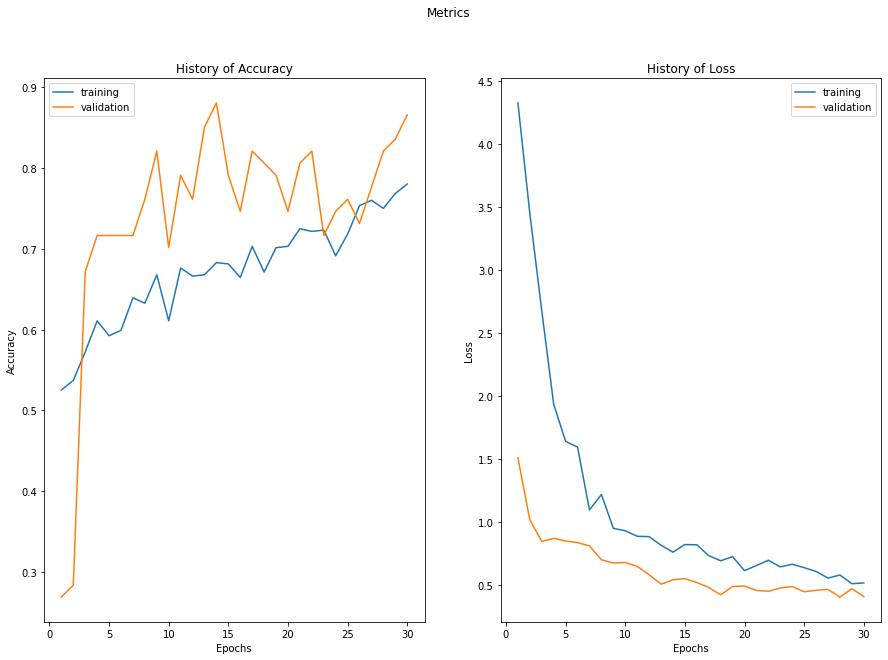

In [ ]:
#@title **Slučaj 2:** *trening VGG19 na generiranim maskama*
# Treniranje na generiranim maskama

lossesAndMetricsVGG = model.fit(np.array(generatedMasks_train_224), classes_train.toarray(), batch_size = 16, epochs=30, validation_data = (np.array(generatedMasks_val_224), classes_val.toarray()), callbacks=[checkpointVGG])
trainValTestMetrics(model, np.array(generatedMasks_train_224), classes_train, np.array(generatedMasks_val_224), classes_val, np.array(generatedMasks_test_224), classes_test)
model.save('/content/drive/My Drive/VGGModelManualNewVal1321850.hdf5')
plotTrainData(lossesAndMetricsVGG.history['acc'], lossesAndMetricsVGG.history['val_acc'], lossesAndMetricsVGG.history['loss'], lossesAndMetricsVGG.history['val_loss'])

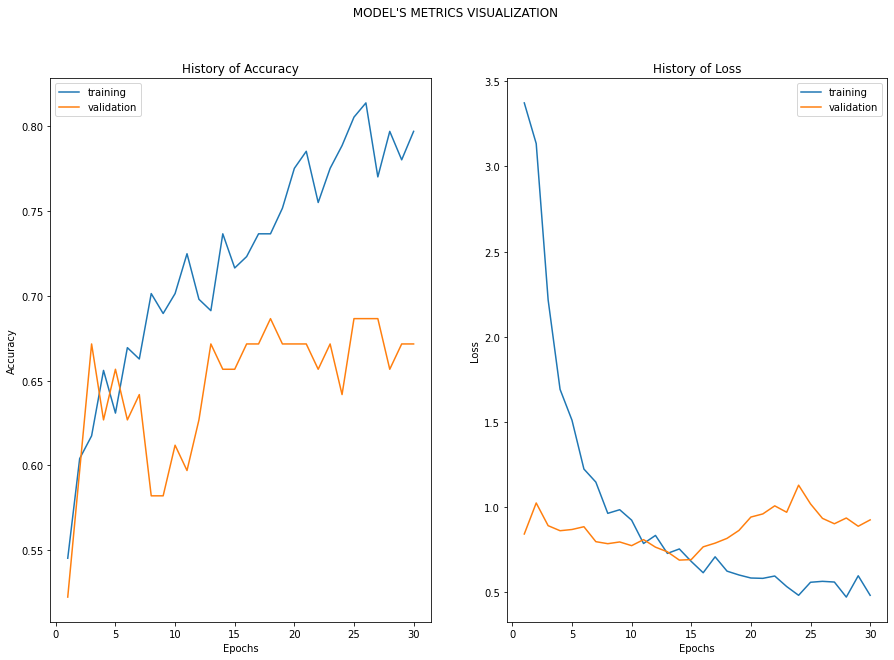

In [ ]:
#@title **Iscrtavanje trening metrika**
plotTrainData(lossesAndMetricsVGG.history['acc'], lossesAndMetricsVGG.history['val_acc'], lossesAndMetricsVGG.history['loss'], lossesAndMetricsVGG.history['val_loss'])

In [ ]:
#@title **Ručna pohrana istrenrirana VGG modela na Google Disk**
# model.save('/content/drive/My Drive/VGGModelManualNewVal.hdf5')